# Traitement naturel du language
## Création d'un RNN pour la classification de phrases en six émotions

----------------------

In [1]:
%load_ext autoreload
import matplotlib.pyplot as plt

In [4]:
%autoreload 2
from RNN import *
from data_processing import *

#### Chargement des données

In [5]:
text, emotion = load_file("./dataset/train.txt")

print(text[2])
print(tokenizer(text[2]))
print(emotion[2])

im grabbing a minute to post i feel greedy wrong
['im', 'grabbing', 'a', 'minute', 'to', 'post', 'i', 'feel', 'greedy', 'wrong']
anger


#### Création de l'ensemble de mots 
1. Lister tous les tokens

In [6]:
lst = list(yield_tokens(text))
print(lst[:50])
print(lst[-50:])

['i', 'didnt', 'feel', 'humiliated', 'i', 'can', 'go', 'from', 'feeling', 'so', 'hopeless', 'to', 'so', 'damned', 'hopeful', 'just', 'from', 'being', 'around', 'someone', 'who', 'cares', 'and', 'is', 'awake', 'im', 'grabbing', 'a', 'minute', 'to', 'post', 'i', 'feel', 'greedy', 'wrong', 'i', 'am', 'ever', 'feeling', 'nostalgic', 'about', 'the', 'fireplace', 'i', 'will', 'know', 'that', 'it', 'is', 'still']
['i', 'feel', 'pathetic', 'that', 'i', 'am', 'still', 'waiting', 'tables', 'and', 'subbing', 'with', 'a', 'teaching', 'degree', 'i', 'feel', 'strong', 'and', 'good', 'overall', 'i', 'feel', 'like', 'this', 'was', 'such', 'a', 'rude', 'comment', 'and', 'im', 'glad', 'that', 't', 'i', 'know', 'a', 'lot', 'but', 'i', 'feel', 'so', 'stupid', 'because', 'i', 'can', 'not', 'portray', 'it']


2. Associer à chaque mot une valeur unique (entier positif) **pas de doublon**

In [7]:
vocab = build_vocab_from_iterator(lst, specials=["<pad>", "<unk>"])
print(len(vocab))
print(vocab["i"])
print(vocab["didnt"])
print(vocab["feel"])
print(vocab["<pad>"])
print(vocab["<unk>"])

15214
2
3
4
1
0


#### Faire pareil avec les émotions, qui représentent les classes

In [8]:
classes = build_vocab_from_iterator(yield_tokens(emotion))
print(len(classes))
print(classes["anger"])

6
1


#### Coder une phrase 
1. Représenter une phrase comme une suite de valeurs

In [9]:
print(text[1])
codage_entier_phrase = [vocab[word] for word in tokenizer(text[1])]
print(codage_entier_phrase)

i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
[2, 6, 7, 8, 9, 10, 11, 12, 10, 13, 14, 15, 8, 16, 17, 18, 19, 20, 21, 22, 23]


2. Représenter chaque phrase comme un tensor d'entiers **seulement à partir de cette étape, on utiliser la librairie pytorch**

In [10]:
tensor_entier = torch.tensor(codage_entier_phrase)
print(tensor_entier)

tensor([ 2,  6,  7,  8,  9, 10, 11, 12, 10, 13, 14, 15,  8, 16, 17, 18, 19, 20,
        21, 22, 23])


3. Représenter chaque phrase comme un tensor one hot **attention, il peut être difficile de charger en mémoire l'ensemble du dataset sous la forme on-hot, privilégier si besoin la génération one-hot par batch, en utilisant un Dataloader**

In [11]:
tensor_one_hot = torch.nn.functional.one_hot(tensor_entier, num_classes=len(vocab))
print(tensor_one_hot)

tensor([[0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


4. Ensuite : 
- Finaliser le codage : 
    - rogner ou compléter les phrase (*pad*) : longeur identique en entrée du réseau quelque soit la phrase 
    - optimiser : *unk* pour les mots sous représentés 
    - préparer le réseau 
    - entrainer le réseau sur la classification des émotions 
    - optimiser, analyser les résultats 
    - entrainer le réseau de façon autosupervisée : prédiction du mots suivant à partir de mots précédents par exemple 
    - analyser l'embeding

#### Rogner ou compléter les phrases

(array([2641., 3795., 3968., 2306., 1499.,  963.,  453.,  251.,  106.,
          18.]),
 array([ 2. ,  8.4, 14.8, 21.2, 27.6, 34. , 40.4, 46.8, 53.2, 59.6, 66. ]),
 <BarContainer object of 10 artists>)

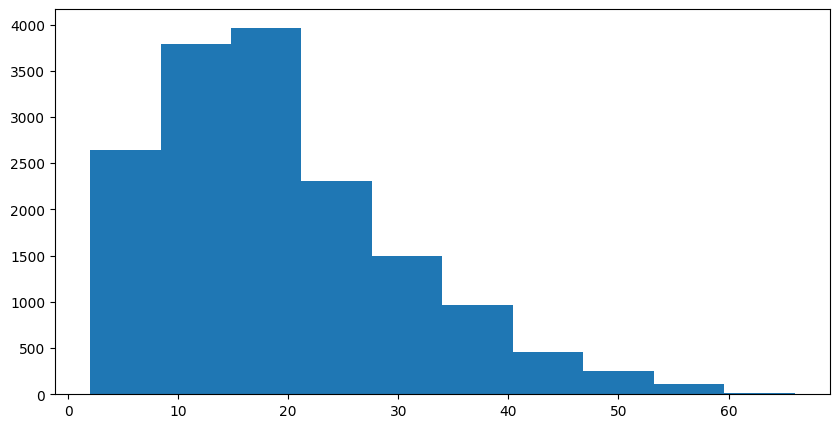

In [12]:
"""sentences_lenght = {}
for sentence in text:
    size = len(sentence)
    sentences_lenght[size] = sentences_lenght.get(size, 0) + 1"""

sentences_lenght = [len(sentence.split(" ")) for sentence in text]

plt.figure(figsize=(10,5))
plt.hist(sentences_lenght)

Au vue de la distribution de la taille des phrases, on peut considérer que ne garder que les phrases de taille inférieure à 20 sera déjà un bon départ pour le réseau

In [13]:
size_threshold = 20
lst = list(yield_tokens(text, threshold=size_threshold))
print(lst[:50])
print(len(lst))

['i', 'didnt', 'feel', 'humiliated', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 'im', 'grabbing', 'a', 'minute', 'to', 'post', 'i', 'feel', 'greedy', 'wrong', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 'i', 'am', 'ever', 'feeling', 'nostalgic', 'about', 'the', 'fireplace', 'i', 'will']
197880


#### Unknown pour les mots sous-représentés

In [14]:
appearance_threshold = 3
lst_with_unk = yield_tokens_with_unknown(lst, threshold=appearance_threshold)
lst_with_unk

['i',
 'didnt',
 'feel',
 'humiliated',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 'im',
 '<unk>',
 'a',
 'minute',
 'to',
 'post',
 'i',
 'feel',
 'greedy',
 'wrong',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 'i',
 'am',
 'ever',
 'feeling',
 'nostalgic',
 'about',
 'the',
 '<unk>',
 'i',
 'will',
 'know',
 'that',
 'it',
 'is',
 'still',
 'on',
 'the',
 '<unk>',
 '<pad>',
 '<pad>',
 'i',
 'am',
 'feeling',
 'grouchy',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 'ive',
 'been',
 'feeling',
 'a',
 'little',
 'burdened',
 'lately',
 'wasnt',
 'sure',
 'why',
 'that',
 'was',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 'i',
 'feel',
 'as',
 'confused',
 'about',


#### Préparer le réseau

1. Batch des données de train (DataLoader)

In [15]:
# parameters for filtering the vocabulary
size_threshold = 20
appearance_threshold = 3

In [16]:
# load text and emotion data for training, validation and test sets
text_train, emotion_train = load_file("./dataset/train.txt")
text_validation , emotion_validation = load_file("./dataset/val.txt")
text_test, emotion_test = load_file("./dataset/test.txt")

# build vocabulary for each set
lst_train_with_unk = list(yield_tokens_with_unknown(list(yield_tokens(text_train, threshold=size_threshold)), 
                                                    threshold=appearance_threshold))
vocab_train = build_vocab_from_iterator(lst_train_with_unk, specials=["<pad>", "<unk>"])

lst_val = list(yield_tokens(text_validation, threshold=size_threshold)) # we do not add <unk> in the validation and test sets, we just replace unknown words (not in the train set) by <unk>
lst_test = list(yield_tokens(text_test, threshold=size_threshold))

# convert to OneHotEncoder dataset
nb_train_sentences = sum(len(sentence.split(" "))<=size_threshold for sentence in text_train)
nb_validation_sentences = sum(len(sentence.split(" "))<=size_threshold for sentence in text_validation)
nb_test_sentences = sum(len(sentence.split(" "))<=size_threshold for sentence in text_test)

print(f"Number of training sentences: {nb_train_sentences}, vocab size: {len(vocab_train)}")
print(f"Number of validation sentences: {nb_validation_sentences}")
print(f"Number of test sentences: {nb_test_sentences}")

Number of training sentences: 9894, vocab size: 2098
Number of validation sentences: 1262
Number of test sentences: 1230


In [17]:
# keep only emotion from sentences of length <= size_threshold
emotion_train = [emotion_train[i] for i in range(len(text_train)) if len(text_train[i].split(" "))<=size_threshold]
emotion_validation = [emotion_validation[i] for i in range(len(text_validation)) if len(text_validation[i].split(" "))<=size_threshold]
emotion_test = [emotion_test[i] for i in range(len(text_test)) if len(text_test[i].split(" "))<=size_threshold]

lst_train_emotion = list(yield_tokens(emotion_train))
emotion_classes = build_vocab_from_iterator(lst_train_emotion) # we build the emotion classes only with the training set

lst_val_emotion = list(yield_tokens(emotion_validation))
lst_test_emotion = list(yield_tokens(emotion_test))

In [18]:
train_dataset = EmotionsDataset(tokenized_text=lst_train_with_unk, 
                              vocab=vocab_train, 
                              nb_sentences=nb_train_sentences, 
                              tokenized_emotion=lst_train_emotion, 
                              emotion_classes=emotion_classes)
validation_dataset = EmotionsDataset(tokenized_text=lst_val, 
                                    vocab=vocab_train, 
                                    nb_sentences=nb_validation_sentences, 
                                    tokenized_emotion=lst_val_emotion, 
                                    emotion_classes=emotion_classes)
test_dataset = EmotionsDataset(tokenized_text=lst_test, 
                              vocab=vocab_train, 
                              nb_sentences=nb_test_sentences, 
                              tokenized_emotion=lst_test_emotion, 
                              emotion_classes=emotion_classes)

In [19]:
print("First sentence of the training set (text):")
print(text_train[0])
print("Associated emotion:", emotion_train[0])
print("First sentence of the training set (one-hot encoded):")
print(train_dataset[0])

First sentence of the training set (text):
i didnt feel humiliated
Associated emotion: sadness
First sentence of the training set (one-hot encoded):
(tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]), tensor([1., 0., 0., 0., 0., 0.]))


Le réseau de neurone prend en entrée de façon récurrente un vecteur : $(batch_{size},vocab_{size})$. Soit par exemple pour un $batch_{size} = 10$, $sentence_{size} = 20$ :
 les dix premiers mots, les dix seconds mots, ..., les dix vingtièmes mots

In [20]:
compute_class_weights(train_dataset[:][1]).numpy()

array([0.5471135, 1.2445283, 2.222372 , 1.338474 , 0.5078534, 4.9371257],
      dtype=float32)

2. Création du modèle

In [21]:
# hyperparameters definition
emb_size = 64 # arbitrary choice
hidden_size = 128 # arbitrary choice
rnn_layers = 1

eta = 1e-3
n_epochs=50

In [22]:
device = "xpu" if torch.xpu.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = ElmanRNN(input_size=len(vocab_train),hidden_size=hidden_size,emb_size=emb_size,output_size=len(emotion_classes),num_layers=rnn_layers, device=device).to(device)
print(model)

Using cuda device
ElmanRNN(
  (i2e): Linear(in_features=2098, out_features=64, bias=True)
  (h2e): Linear(in_features=128, out_features=64, bias=True)
  (i2h): Linear(in_features=192, out_features=128, bias=True)
  (i2o): Linear(in_features=192, out_features=6, bias=True)
)


In [23]:
loss_func = torch.nn.CrossEntropyLoss(reduction='mean')
optim = torch.optim.Adam(model.parameters(), lr=eta) # trouver la méthode pour faire un équilibrage des classes dans un second temps

3. Test du modèle (sans/avec récurrence, phrase unique/batch)

In [11]:
# Test with no recurrence (single word to predict the emotion, batch_size=1)
batch_size = 1

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, vocab_train))
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: collate_fn(x, vocab_train))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: collate_fn(x, vocab_train))

batch = next(iter(train_loader))
model.eval()
with torch.no_grad():
    X, y, lengths = batch
    pred, _ = model.forward_sequence(X.to(device), lengths=lengths.to(device), recurrence=False)
    pred = torch.nn.functional.log_softmax(pred, dim=1)
    for prediction, target in zip(pred, y):
        print(prediction, target)

tensor([-1.7548, -1.7721, -1.7480, -1.8273, -1.8295, -1.8225], device='xpu:0') tensor([1., 0., 0., 0., 0., 0.])


In [12]:
# Test of the network, calling it with recurrence (batch_size=1)
batch_size = 1

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, vocab_train))
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: collate_fn(x, vocab_train))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: collate_fn(x, vocab_train))

batch = next(iter(train_loader))
model.eval()
with torch.no_grad():
    X, y, lengths = batch
    pred, _ = model.forward_sequence(X.to(device), lengths=lengths.to(device), recurrence=True)
    pred = torch.nn.functional.log_softmax(pred, dim=1)
    for prediction, target in zip(pred, y):
        print(prediction, target)

tensor([-1.7711, -1.7449, -1.7417, -1.8440, -1.7919, -1.8634], device='xpu:0') tensor([0., 0., 0., 0., 1., 0.])


In [13]:
# Test of the network, calling it with recurrence (batch_size>1)
batch_size = 10

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, vocab_train))
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: collate_fn(x, vocab_train))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: collate_fn(x, vocab_train))

batch = next(iter(train_loader))
model.eval()
with torch.no_grad():
    X, y, lengths = batch
    pred, _ = model.forward_sequence(X.to(device), lengths=lengths.to(device), recurrence=True)
    pred = torch.nn.functional.log_softmax(pred, dim=1)
    for prediction, target in zip(pred, y):
        print(prediction, target)

tensor([-1.7555, -1.7445, -1.7488, -1.8387, -1.7967, -1.8734], device='xpu:0') tensor([0., 1., 0., 0., 0., 0.])
tensor([-1.7606, -1.7444, -1.7439, -1.8403, -1.7988, -1.8696], device='xpu:0') tensor([0., 0., 0., 1., 0., 0.])
tensor([-1.7636, -1.7463, -1.7428, -1.8288, -1.7991, -1.8768], device='xpu:0') tensor([0., 1., 0., 0., 0., 0.])
tensor([-1.7647, -1.7460, -1.7341, -1.8492, -1.8039, -1.8598], device='xpu:0') tensor([1., 0., 0., 0., 0., 0.])
tensor([-1.7637, -1.7507, -1.7382, -1.8357, -1.7954, -1.8739], device='xpu:0') tensor([1., 0., 0., 0., 0., 0.])
tensor([-1.7679, -1.7420, -1.7373, -1.8387, -1.7978, -1.8744], device='xpu:0') tensor([1., 0., 0., 0., 0., 0.])
tensor([-1.7604, -1.7441, -1.7415, -1.8465, -1.7984, -1.8669], device='xpu:0') tensor([1., 0., 0., 0., 0., 0.])
tensor([-1.7641, -1.7420, -1.7460, -1.8445, -1.7923, -1.8687], device='xpu:0') tensor([0., 0., 0., 1., 0., 0.])
tensor([-1.7640, -1.7412, -1.7459, -1.8383, -1.8013, -1.8665], device='xpu:0') tensor([0., 1., 0., 0., 0

#### Entrainer le réseau sur la classification des émotions

In [30]:
# -------------------------
# 7) Pipeline
# -------------------------
def run_pipeline(train_path: str, val_path: str, test_path: str,
                 sep: str = ";",
                 specials: list[str] = ["<pad>", "<unk>"],
                 min_freq: int = 1,
                 batch_size: int = 64,
                 hidden_size: int = 128,
                 emb_size: int = 64,
                 n_epochs: int = 20,
                 lr: float = 1e-3,
                 size_threshold: int = 20,
                 appearance_threshold: int = 3,
                 rnn_layers: int = 1,
                 device = None):
    if device is None:
        device = torch.device("xpu" if torch.xpu.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # 1) load
    train_texts, train_labels = load_file(train_path, sep=sep)
    val_texts, val_labels = load_file(val_path, sep=sep)
    test_texts, test_labels = load_file(test_path, sep=sep)

    # Check if datasets are empty
    if not train_texts or not train_labels:
        print(f"Error: Training data is empty after loading from {train_path}. Please check the file path and separator.")
        return None, None, None, None, None # Return None for all outputs
    if not val_texts or not val_labels:
        print(f"Error: Validation data is empty after loading from {val_path}. Please check the file path and separator.")
        return None, None, None, None, None # Return None for all outputs
    if not test_texts or not test_labels:
        print(f"Error: Test data is empty after loading from {test_path}. Please check the file path and separator.")
        return None, None, None, None, None # Return None for all outputs
    

    # 2) vocab
    # tokens iterator uses only train
    # voc = build_vocab_from_iterator(yield_tokens(train_texts), specials=specials)
    lst_train_with_unk = list(yield_tokens_with_unknown(list(yield_tokens(train_texts, threshold=size_threshold)), 
                                                    threshold=appearance_threshold))
    lst_val = list(yield_tokens(val_texts, threshold=size_threshold)) # we do not add <unk> in the validation and test sets, we just replace unknown words (not in the train set) by <unk>
    lst_test = list(yield_tokens(test_texts, threshold=size_threshold))

    voc = build_vocab_from_iterator(lst_train_with_unk, specials=["<pad>", "<unk>"])
    print("Vocab size:", len(voc))
    # reverse mapping
    itos = {idx: token for token, idx in voc.items()}

    nb_train_sentences = sum(len(sentence.split(" "))<=size_threshold for sentence in train_texts)
    nb_validation_sentences = sum(len(sentence.split(" "))<=size_threshold for sentence in val_texts)
    nb_test_sentences = sum(len(sentence.split(" "))<=size_threshold for sentence in test_texts)

    # classes vocab
    emotion_train = [train_labels[i] for i in range(len(train_texts)) if len(train_texts[i].split(" "))<=size_threshold]
    emotion_validation = [val_labels[i] for i in range(len(val_texts)) if len(val_texts[i].split(" "))<=size_threshold]
    emotion_test = [test_labels[i] for i in range(len(test_texts)) if len(test_texts[i].split(" "))<=size_threshold]

    # keep only emotion from sentences of length <= size_threshold
    lst_train_emotion = list(yield_tokens(emotion_train))
    lst_val_emotion = list(yield_tokens(emotion_validation))
    lst_test_emotion = list(yield_tokens(emotion_test))

    classes = build_vocab_from_iterator(lst_train_emotion, specials=[])
    label2idx = {lab: idx for lab, idx in classes.items()}
    idx2label = {v:k for k,v in label2idx.items()}
    print("Num classes:", len(label2idx), "classes:", list(label2idx.keys()))

    # 3) datasets + loaders
    train_dataset = EmotionsDataset(tokenized_text=lst_train_with_unk, 
                              vocab=voc, 
                              nb_sentences=nb_train_sentences, 
                              tokenized_emotion=lst_train_emotion, 
                              emotion_classes=classes)
    val_dataset = EmotionsDataset(tokenized_text=lst_val, 
                                    vocab=voc, 
                                    nb_sentences=nb_validation_sentences, 
                                    tokenized_emotion=lst_val_emotion, 
                                    emotion_classes=classes)
    test_dataset = EmotionsDataset(tokenized_text=lst_test, 
                              vocab=voc, 
                              nb_sentences=nb_test_sentences, 
                              tokenized_emotion=lst_test_emotion, 
                              emotion_classes=classes)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, voc))
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: collate_fn(x, voc))
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: collate_fn(x, voc))

    # 4) model
    vocab_size = len(voc)
    num_classes = len(classes)
    model = ElmanRNN(input_size=vocab_size, hidden_size=hidden_size, emb_size=emb_size, output_size=num_classes, num_layers=rnn_layers, device=device).to(device)

    # 5) class weights
    class_weights = compute_class_weights(train_dataset[:][1]).to(device)
    # We'll handle potential zero weight (class not present) by replacing zeros with 0.0
    class_weights[class_weights == 0.0] = 0.0
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 6) train loop with early stopping
    best_val_acc = 0.0
    patience = 0
    early_stop = 5
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_path = "best_elman_rnn.pt"

    for epoch in range(1, n_epochs + 1):
        tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion, device, recurrence=True)
        val_loss, val_acc, _, _ = eval_epoch(model, val_loader, criterion, device, recurrence=True)
        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)
        print(f"Epoch {epoch:02d} | Train loss {tr_loss:.4f} acc {tr_acc:.4f} | Val loss {val_loss:.4f} acc {val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience = 0
            torch.save(model.state_dict(), best_path)
            print("  -> saved model")
        else:
            patience += 1
            if patience >= early_stop:
                print("Early stop")
                break

    # load best model
    model.load_state_dict(torch.load(best_path))
    test_loss, test_acc, y_true, y_pred = eval_epoch(model, test_loader, criterion, device, recurrence=True)
    print(f"Test loss {test_loss:.4f} acc {test_acc:.4f}")
    print(classification_report(y_true, y_pred, target_names=[idx2label[i] for i in range(len(idx2label))]))

    # Visualisations demandées
    plot_learning(history)
    plot_confusion(y_true, y_pred, [idx2label[i] for i in range(len(idx2label))])

    # Embedding matrix - ici l'embedding est implicite : la "matrice d'embedding"
    # correspond à la matrice de poids de i2h / i2o si on voulait en extraire
    # Ici on peut extraire les colonnes correspondantes en simulant une one-hot for each token:
    # For token i, combined = [one_hot(i), zeros(hidden)] so i2h.weight[:, :vocab_size] acts like embedding
    with torch.no_grad():
        # i2e weight shape: (emb_size, input_size)
        w_i2e = model.i2e.weight[:, :vocab_size].cpu().numpy().T  # (vocab_size, emb_size)
        # optionally reduce dim to visualize
        visualize_embeddings_pca_tsne(w_i2e, itos, top_n=200)

    return model, voc, itos, label2idx, history

Device: xpu
Vocab size: 3721
Num classes: 6 classes: ['sadness', 'anger', 'love', 'fear', 'joy', 'surprise']
Epoch 01 | Train loss 1.7667 acc 0.3197 | Val loss 1.6235 acc 0.5547
  -> saved model
Epoch 02 | Train loss 1.0814 acc 0.7046 | Val loss 0.7570 acc 0.7876
  -> saved model
Epoch 03 | Train loss 0.4213 acc 0.8783 | Val loss 0.5246 acc 0.8685
  -> saved model
Epoch 04 | Train loss 0.2247 acc 0.9307 | Val loss 0.5567 acc 0.8590
Epoch 05 | Train loss 0.1744 acc 0.9427 | Val loss 0.5026 acc 0.8352
Epoch 06 | Train loss 0.1555 acc 0.9482 | Val loss 0.4959 acc 0.8748
  -> saved model
Epoch 07 | Train loss 0.1144 acc 0.9623 | Val loss 0.5329 acc 0.8732
Epoch 08 | Train loss 0.0893 acc 0.9718 | Val loss 0.5114 acc 0.8732
Epoch 09 | Train loss 0.1019 acc 0.9669 | Val loss 0.4997 acc 0.8796
  -> saved model
Epoch 10 | Train loss 0.0719 acc 0.9767 | Val loss 0.4594 acc 0.8883
  -> saved model
Epoch 11 | Train loss 0.0546 acc 0.9812 | Val loss 0.5313 acc 0.8867
Epoch 12 | Train loss 0.0703 a

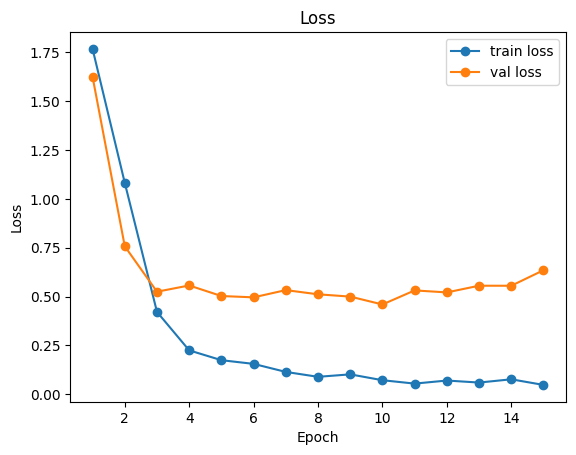

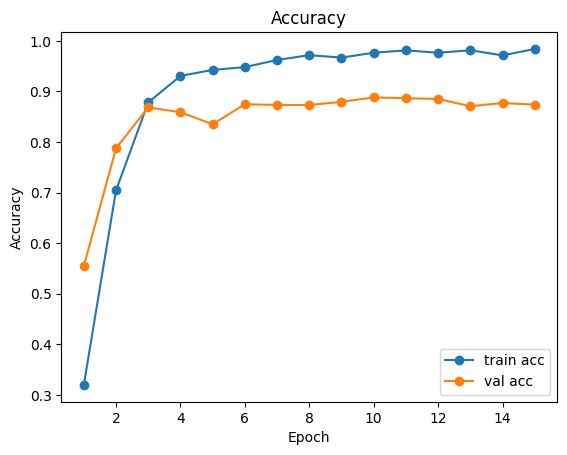

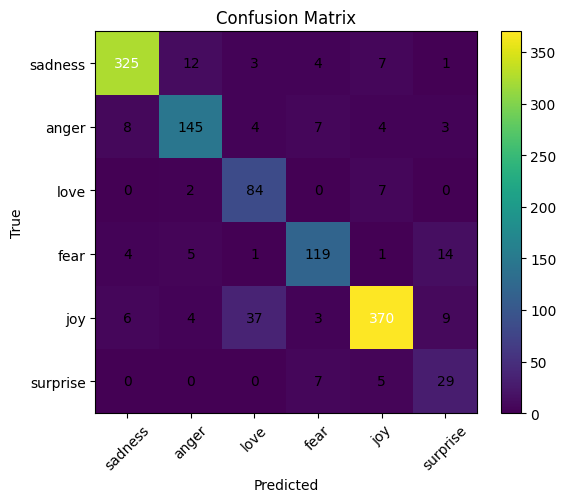

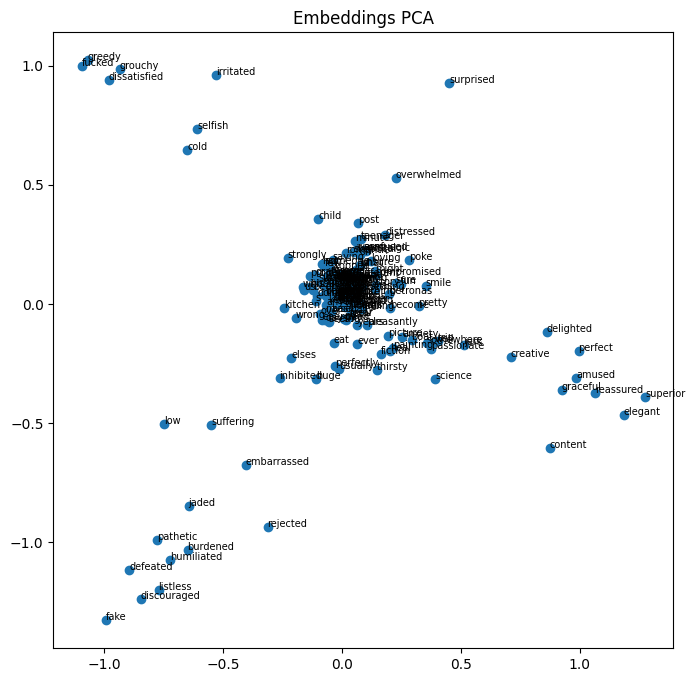

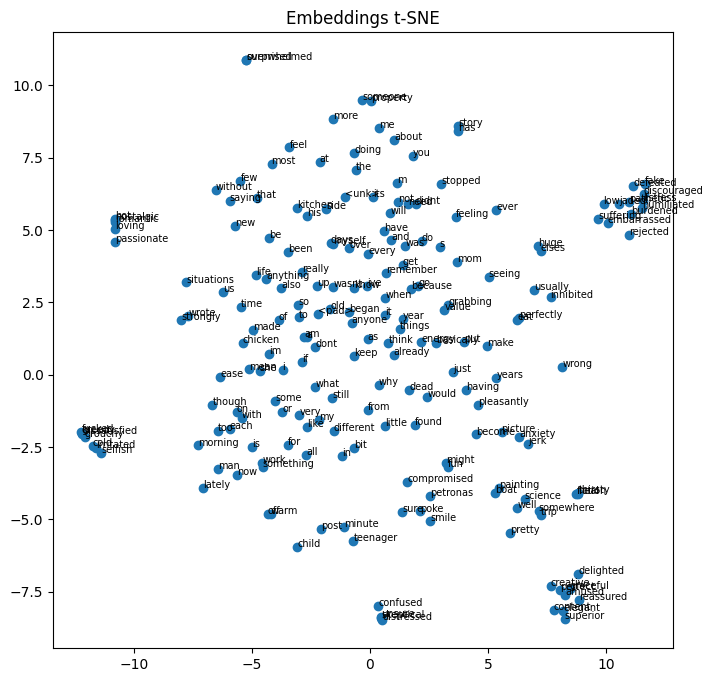

In [11]:
train_path = "./dataset/train.txt"
val_path = "./dataset/val.txt"
test_path = "./dataset/test.txt"

model, vocab, itos, label2idx, history = run_pipeline(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    sep=";",
    specials=["<pad>", "<unk>"],
    batch_size=64,
    hidden_size=128,
    emb_size=64,
    n_epochs=20,
    lr=1e-3,
    size_threshold=20,
    appearance_threshold=1,
    rnn_layers=1,
)

Device: xpu
Vocab size: 3721
Num classes: 6 classes: ['sadness', 'anger', 'love', 'fear', 'joy', 'surprise']
Epoch 01 | Train loss 1.6714 acc 0.2878 | Val loss 1.2625 acc 0.6490
  -> saved model
Epoch 02 | Train loss 0.8197 acc 0.7638 | Val loss 0.5860 acc 0.8170
  -> saved model
Epoch 03 | Train loss 0.3126 acc 0.9027 | Val loss 0.4366 acc 0.8566
  -> saved model
Epoch 04 | Train loss 0.1741 acc 0.9385 | Val loss 0.4229 acc 0.8629
  -> saved model
Epoch 05 | Train loss 0.1373 acc 0.9524 | Val loss 0.5104 acc 0.8550
Epoch 06 | Train loss 0.1539 acc 0.9482 | Val loss 0.5483 acc 0.8510
Epoch 07 | Train loss 0.0872 acc 0.9706 | Val loss 0.4942 acc 0.8637
  -> saved model
Epoch 08 | Train loss 0.1191 acc 0.9546 | Val loss 0.6069 acc 0.8621
Epoch 09 | Train loss 0.1026 acc 0.9606 | Val loss 0.5496 acc 0.8479
Epoch 10 | Train loss 0.0684 acc 0.9765 | Val loss 0.6693 acc 0.8439
Epoch 11 | Train loss 0.0566 acc 0.9831 | Val loss 0.6853 acc 0.8550
Epoch 12 | Train loss 0.0523 acc 0.9846 | Val l

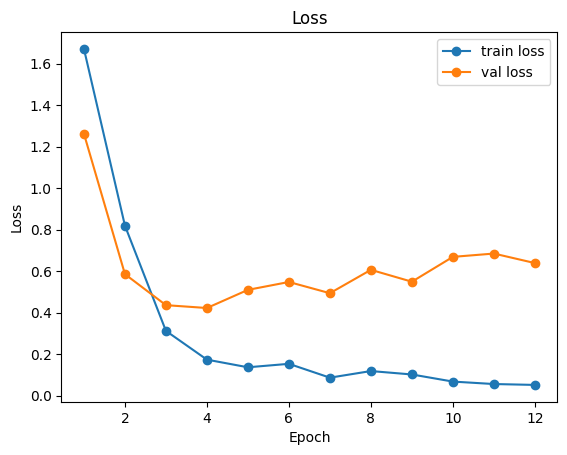

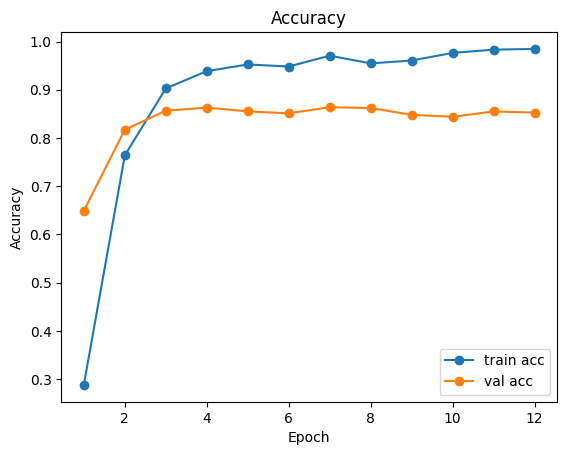

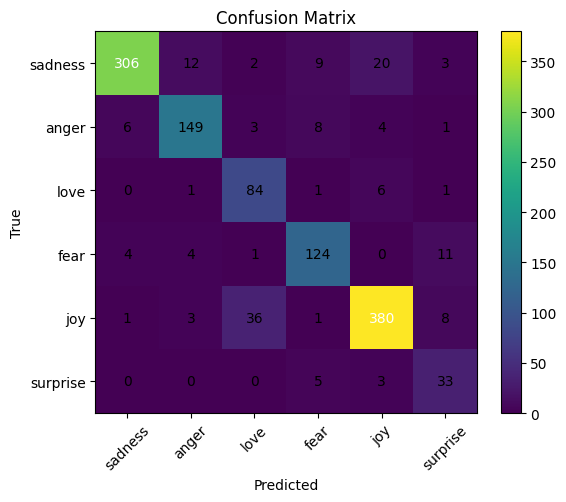

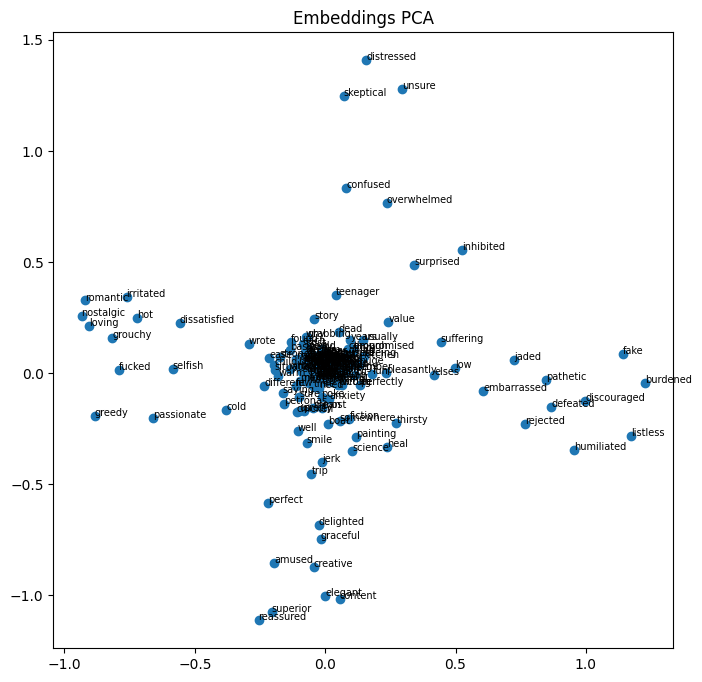

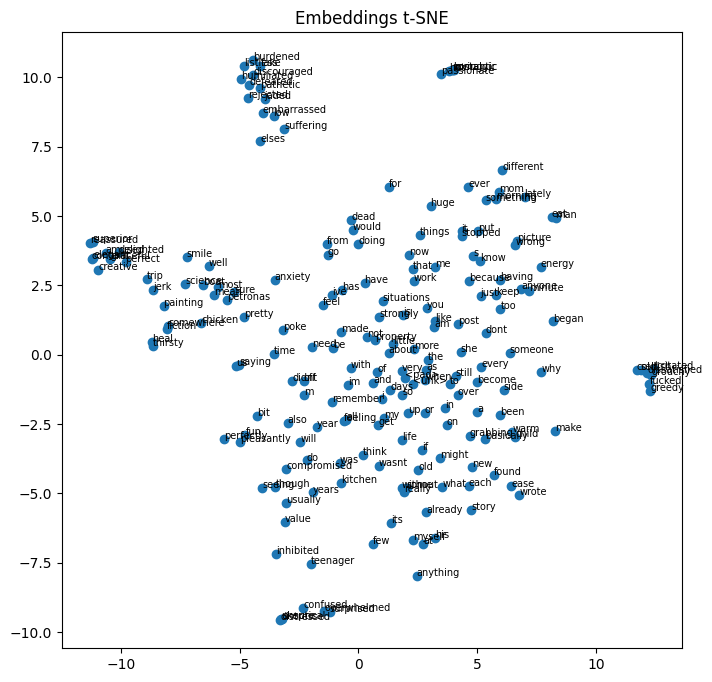

In [13]:
# Nouvelle exécution avec emb_size=hidden_size et rnn_layers=3 (test du modèle avec layers empilées)
train_path = "./dataset/train.txt"
val_path = "./dataset/val.txt"
test_path = "./dataset/test.txt"

model, vocab, itos, label2idx, history = run_pipeline(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    sep=";",
    specials=["<pad>", "<unk>"],
    batch_size=64,
    hidden_size=128,
    emb_size=128, # same as hidden 
    n_epochs=20,
    lr=1e-3,
    size_threshold=20,
    appearance_threshold=1,
    rnn_layers=3, # multiple layers
)

La visualisation des embeddings nous montre qu'il est possible d'obtenir quelques cluster de mots similaires (voir rapport pour interprétation complète).

In [42]:
# Update de la fonction run_pipeline pour qu'on n'affiche les visualisations que pour le meilleur modèle

def run_pipeline(train_path: str, val_path: str, test_path: str,
                 sep: str = ";",
                 specials: list[str] = ["<pad>", "<unk>"],
                 min_freq: int = 1,
                 batch_size: int = 64,
                 hidden_size: int = 128,
                 emb_size: int = 64,
                 n_epochs: int = 20,
                 lr: float = 1e-3,
                 size_threshold: int = 20,
                 appearance_threshold: int = 3,
                 rnn_layers: int = 1,
                 device = None,
                 visualize: bool = True,   # < new: control visualizations
                 verbose: bool = True,     # < new: control printing
                 best_path: str = None):   # < new: allow unique path per run
    import time
    if device is None:
        device = torch.device("xpu" if torch.xpu.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    if best_path is None:
        best_path = f"best_elman_rnn_{int(time.time())}.pt"

    if verbose:
        print("Device:", device)

    train_texts, train_labels = load_file(train_path, sep=sep)
    val_texts, val_labels = load_file(val_path, sep=sep)
    test_texts, test_labels = load_file(test_path, sep=sep)

    if not train_texts or not train_labels:
        if verbose: print(f"Error: Training data is empty after loading from {train_path}. Please check the file path and separator.")
        return None, None, None, None, None, None
    if not val_texts or not val_labels:
        if verbose: print(f"Error: Validation data is empty after loading from {val_path}. Please check the file path and separator.")
        return None, None, None, None, None, None
    if not test_texts or not test_labels:
        if verbose: print(f"Error: Test data is empty after loading from {test_path}. Please check the file path and separator.")
        return None, None, None, None, None, None

    lst_train_with_unk = list(yield_tokens_with_unknown(list(yield_tokens(train_texts, threshold=size_threshold)),
                                                    threshold=appearance_threshold))
    lst_val = list(yield_tokens(val_texts, threshold=size_threshold))
    lst_test = list(yield_tokens(test_texts, threshold=size_threshold))

    voc = build_vocab_from_iterator(lst_train_with_unk, specials=["<pad>", "<unk>"])
    if verbose: print("Vocab size:", len(voc))
    itos = {idx: token for token, idx in voc.items()}

    nb_train_sentences = sum(len(sentence.split(" "))<=size_threshold for sentence in train_texts)
    nb_validation_sentences = sum(len(sentence.split(" "))<=size_threshold for sentence in val_texts)
    nb_test_sentences = sum(len(sentence.split(" "))<=size_threshold for sentence in test_texts)

    # classes vocab
    emotion_train = [train_labels[i] for i in range(len(train_texts)) if len(train_texts[i].split(" "))<=size_threshold]
    emotion_validation = [val_labels[i] for i in range(len(val_texts)) if len(val_texts[i].split(" "))<=size_threshold]
    emotion_test = [test_labels[i] for i in range(len(test_texts)) if len(test_texts[i].split(" "))<=size_threshold]

    lst_train_emotion = list(yield_tokens(emotion_train))
    lst_val_emotion = list(yield_tokens(emotion_validation))
    lst_test_emotion = list(yield_tokens(emotion_test))

    classes = build_vocab_from_iterator(lst_train_emotion, specials=[])
    label2idx = {lab: idx for lab, idx in classes.items()}
    idx2label = {v:k for k,v in label2idx.items()}
    if verbose: print("Num classes:", len(label2idx), "classes:", list(label2idx.keys()))

    train_dataset = EmotionsDataset(tokenized_text=lst_train_with_unk,
                              vocab=voc,
                              nb_sentences=nb_train_sentences,
                              tokenized_emotion=lst_train_emotion,
                              emotion_classes=classes)
    val_dataset = EmotionsDataset(tokenized_text=lst_val,
                                    vocab=voc,
                                    nb_sentences=nb_validation_sentences,
                                    tokenized_emotion=lst_val_emotion,
                                    emotion_classes=classes)
    test_dataset = EmotionsDataset(tokenized_text=lst_test,
                              vocab=voc,
                              nb_sentences=nb_test_sentences,
                              tokenized_emotion=lst_test_emotion,
                              emotion_classes=classes)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, voc))
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: collate_fn(x, voc))
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: collate_fn(x, voc))

    vocab_size = len(voc)
    num_classes = len(classes)
    model = ElmanRNN(input_size=vocab_size, hidden_size=hidden_size, emb_size=emb_size, output_size=num_classes, num_layers=rnn_layers, device=device).to(device)

    class_weights = compute_class_weights(train_dataset[:][1]).to(device)
    class_weights[class_weights == 0.0] = 0.0
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # train loop with early stopping
    best_val_acc = 0.0
    patience = 0
    early_stop = 5
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if verbose: print(f"Training for {n_epochs} epochs, saving best model to {best_path}")
    for epoch in range(1, n_epochs + 1):
        tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion, device, recurrence=True)
        val_loss, val_acc, _, _ = eval_epoch(model, val_loader, criterion, device, recurrence=True)
        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)
        if verbose:
            print(f"Epoch {epoch:02d} | Train loss {tr_loss:.4f} acc {tr_acc:.4f} | Val loss {val_loss:.4f} acc {val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience = 0
            torch.save(model.state_dict(), best_path)
            if verbose: print("  -> saved model")
        else:
            patience += 1
            if patience >= early_stop:
                if verbose: print("Early stop")
                break

    # loading best model
    model.load_state_dict(torch.load(best_path))
    test_loss, test_acc, y_true, y_pred = eval_epoch(model, test_loader, criterion, device, recurrence=True)
    if verbose: print(f"Test loss {test_loss:.4f} acc {test_acc:.4f}")
    if verbose: print(classification_report(y_true, y_pred, target_names=[idx2label[i] for i in range(len(idx2label))]))

    # Visualisations : n'exécuter que si visualize==True
    if visualize:
        plot_learning(history)
        plot_confusion(y_true, y_pred, [idx2label[i] for i in range(len(idx2label))])
        with torch.no_grad():
            w_i2e = model.i2e.weight[:, :vocab_size].cpu().numpy().T  # (vocab_size, emb_size)
            visualize_embeddings_pca_tsne(w_i2e, itos, top_n=200)

    return model, voc, itos, label2idx, history, best_path

In [ ]:
# L'objectif de ce code est de mesurer l'impact de l'appearance threshold afin d'optimiser le choix des valeurs des hyperparamètres à tester
def threshold_stats(texts, size_threshold, thresholds=(1,3)):
    from collections import Counter
    texts = [t for t in texts if len(t.split())<=size_threshold]
    flat = [w for s in texts for w in s.split()]
    freq = Counter(flat)
    out = {}
    for th in thresholds:
        kept = sum(1 for w,c in freq.items() if c>=th)
        total_tokens = sum(freq.values())
        tokens_kept = sum(c for w,c in freq.items() if c>=th)
        unk_tokens = total_tokens - tokens_kept
        out[th] = {
            "vocab_size": kept + 2,   # +2 for <pad>,<unk>
            "unique_tokens_total": len(freq),
            "total_token_occurrences": total_tokens,
            "unk_token_occurrences": unk_tokens,
            "pct_tokens_replaced_by_unk": unk_tokens/total_tokens
        }
    return out

train_texts, _ = load_file("./dataset/train.txt")
print(threshold_stats(train_texts, size_threshold=20, thresholds=(1,2,3)))

{1: {'vocab_size': 8298, 'unique_tokens_total': 8296, 'total_token_occurrences': 120262, 'unk_token_occurrences': 0, 'pct_tokens_replaced_by_unk': 0.0}, 2: {'vocab_size': 3721, 'unique_tokens_total': 8296, 'total_token_occurrences': 120262, 'unk_token_occurrences': 4577, 'pct_tokens_replaced_by_unk': 0.03805857211754336}, 3: {'vocab_size': 2607, 'unique_tokens_total': 8296, 'total_token_occurrences': 120262, 'unk_token_occurrences': 6805, 'pct_tokens_replaced_by_unk': 0.05658478987543863}}


Je choisis pour l'appearance thereshold les valeurs 1 et 3 pour l'hyperparameter tuning donc. Ce choix permet de comparer l'extrême (tout garder) à un seuil raisonnable qui réduit fortement le vocabulaire tout en ne remplaçant qu'une faible proportion de tokens (~5%), offrant un bon compromis entre performance et coût mémoire/temps

In [ ]:
import itertools
import time
import random
import os

# Hyperparameter tuning (grid search with optional random sampling)
# Par défaut on échantillonne un sous-ensemble (max_trials) pour éviter un grid complet trop lourd.


train_path = "./dataset/train.txt"
val_path = "./dataset/val.txt"
test_path = "./dataset/test.txt"

param_grid = {
    "emb_size": [128], # largement suffisant pour capturer la sémantique et va réduire le temps de calcul par la moitié
    "hidden_size": [128, 256],
    "rnn_layers": [1, 2, 3], 
    "appearance_threshold": [1, 3],
    "size_threshold": [20, 25], 
    "batch_size": [64, 128],
    "lr": [1e-3, 5e-4],
}

# Nombre maximal d'expériences à lancer 
max_trials = 500 

# Autres hyperparams fixes
n_epochs = 20
sep = ";"
specials = ["<pad>", "<unk>"]

# Construire toutes les combinaisons
keys, values = zip(*param_grid.items())
all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
total = len(all_combinations)
print(f"Total combinaisons dans la grille: {total}")

# Échantillonnage si demandé
if max_trials is not None and max_trials < total:
    random.seed(42)
    sampled = random.sample(all_combinations, k=max_trials)
    combinations = sampled
    print(f"Échantillonnage aléatoire de {max_trials} configurations.")
else:
    combinations = all_combinations
    print("Parcours de la grille complète.")

Total combinaisons dans la grille: 96
Parcours de la grille complète.


In [ ]:
# On définie la liste des résultats avant la boucle
results = []

# Results tracking inside the loop
for idx, cfg in enumerate(combinations, 1):
    print(f"\n=== Trial {idx}/{len(combinations)} ===")
    print(cfg)
    start = time.time()
    try:
        trial_best_path = f"best_elman_rnn_trial_{idx}.pt"
        model, voc, itos, label2idx, history, saved_path = run_pipeline(
            train_path=train_path,
            val_path=val_path,
            test_path=test_path,
            sep=sep,
            specials=specials,
            min_freq=1,
            batch_size=cfg["batch_size"],
            hidden_size=cfg["hidden_size"],
            emb_size=cfg["emb_size"],
            n_epochs=n_epochs,
            lr=cfg["lr"],
            size_threshold=cfg["size_threshold"],
            appearance_threshold=cfg["appearance_threshold"],
            rnn_layers=cfg["rnn_layers"],
            visualize=False,   # disable heavy visualizations
            verbose=False,     # minimal printing
            best_path=trial_best_path
        )
        best_val_acc = max(history['val_acc']) if history and 'val_acc' in history else None
        epoch_of_best = history['val_acc'].index(best_val_acc) + 1 if best_val_acc is not None else None
        elapsed = time.time() - start
        results.append({
            **cfg,
            "best_val_acc": best_val_acc,
            "epoch_of_best": epoch_of_best,
            "time_s": elapsed,
            "status": "ok",
            "best_path": saved_path
        })
    except Exception as e:
        elapsed = time.time() - start
        print(f"Error during trial: {str(e)}")
        results.append({
            **cfg,
            "best_val_acc": None, 
            "epoch_of_best": None,
            "time_s": elapsed,
            "status": f"error: {str(e)}"
        })

    finally:
        # Clear GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


=== Trial 1/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 1, 'appearance_threshold': 1, 'size_threshold': 20, 'batch_size': 64, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 2/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 1, 'appearance_threshold': 1, 'size_threshold': 20, 'batch_size': 64, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 3/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 1, 'appearance_threshold': 1, 'size_threshold': 20, 'batch_size': 128, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 4/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 1, 'appearance_threshold': 1, 'size_threshold': 20, 'batch_size': 128, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 5/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 1, 'appearance_threshold': 1, 'size_threshold': 25, 'batch_size': 64, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 6/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 1, 'appearance_threshold': 1, 'size_threshold': 25, 'batch_size': 64, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 7/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 1, 'appearance_threshold': 1, 'size_threshold': 25, 'batch_size': 128, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 8/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 1, 'appearance_threshold': 1, 'size_threshold': 25, 'batch_size': 128, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 9/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 1, 'appearance_threshold': 3, 'size_threshold': 20, 'batch_size': 64, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 10/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 1, 'appearance_threshold': 3, 'size_threshold': 20, 'batch_size': 64, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 11/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 1, 'appearance_threshold': 3, 'size_threshold': 20, 'batch_size': 128, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 12/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 1, 'appearance_threshold': 3, 'size_threshold': 20, 'batch_size': 128, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 13/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 1, 'appearance_threshold': 3, 'size_threshold': 25, 'batch_size': 64, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 14/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 1, 'appearance_threshold': 3, 'size_threshold': 25, 'batch_size': 64, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 15/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 1, 'appearance_threshold': 3, 'size_threshold': 25, 'batch_size': 128, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 16/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 1, 'appearance_threshold': 3, 'size_threshold': 25, 'batch_size': 128, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 17/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 2, 'appearance_threshold': 1, 'size_threshold': 20, 'batch_size': 64, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 18/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 2, 'appearance_threshold': 1, 'size_threshold': 20, 'batch_size': 64, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 19/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 2, 'appearance_threshold': 1, 'size_threshold': 20, 'batch_size': 128, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 20/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 2, 'appearance_threshold': 1, 'size_threshold': 20, 'batch_size': 128, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 21/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 2, 'appearance_threshold': 1, 'size_threshold': 25, 'batch_size': 64, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 22/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 2, 'appearance_threshold': 1, 'size_threshold': 25, 'batch_size': 64, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 23/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 2, 'appearance_threshold': 1, 'size_threshold': 25, 'batch_size': 128, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 24/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 2, 'appearance_threshold': 1, 'size_threshold': 25, 'batch_size': 128, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 25/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 2, 'appearance_threshold': 3, 'size_threshold': 20, 'batch_size': 64, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 26/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 2, 'appearance_threshold': 3, 'size_threshold': 20, 'batch_size': 64, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 27/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 2, 'appearance_threshold': 3, 'size_threshold': 20, 'batch_size': 128, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 28/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 2, 'appearance_threshold': 3, 'size_threshold': 20, 'batch_size': 128, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 29/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 2, 'appearance_threshold': 3, 'size_threshold': 25, 'batch_size': 64, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 30/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 2, 'appearance_threshold': 3, 'size_threshold': 25, 'batch_size': 64, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 31/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 2, 'appearance_threshold': 3, 'size_threshold': 25, 'batch_size': 128, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 32/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 2, 'appearance_threshold': 3, 'size_threshold': 25, 'batch_size': 128, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 33/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 3, 'appearance_threshold': 1, 'size_threshold': 20, 'batch_size': 64, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 34/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 3, 'appearance_threshold': 1, 'size_threshold': 20, 'batch_size': 64, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 35/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 3, 'appearance_threshold': 1, 'size_threshold': 20, 'batch_size': 128, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 36/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 3, 'appearance_threshold': 1, 'size_threshold': 20, 'batch_size': 128, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 37/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 3, 'appearance_threshold': 1, 'size_threshold': 25, 'batch_size': 64, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 38/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 3, 'appearance_threshold': 1, 'size_threshold': 25, 'batch_size': 64, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 39/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 3, 'appearance_threshold': 1, 'size_threshold': 25, 'batch_size': 128, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 40/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 3, 'appearance_threshold': 1, 'size_threshold': 25, 'batch_size': 128, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 41/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 3, 'appearance_threshold': 3, 'size_threshold': 20, 'batch_size': 64, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 42/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 3, 'appearance_threshold': 3, 'size_threshold': 20, 'batch_size': 64, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 43/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 3, 'appearance_threshold': 3, 'size_threshold': 20, 'batch_size': 128, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 44/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 3, 'appearance_threshold': 3, 'size_threshold': 20, 'batch_size': 128, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 45/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 3, 'appearance_threshold': 3, 'size_threshold': 25, 'batch_size': 64, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 46/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 3, 'appearance_threshold': 3, 'size_threshold': 25, 'batch_size': 64, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 47/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 3, 'appearance_threshold': 3, 'size_threshold': 25, 'batch_size': 128, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 48/96 ===
{'emb_size': 128, 'hidden_size': 128, 'rnn_layers': 3, 'appearance_threshold': 3, 'size_threshold': 25, 'batch_size': 128, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 49/96 ===
{'emb_size': 128, 'hidden_size': 256, 'rnn_layers': 1, 'appearance_threshold': 1, 'size_threshold': 20, 'batch_size': 64, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 50/96 ===
{'emb_size': 128, 'hidden_size': 256, 'rnn_layers': 1, 'appearance_threshold': 1, 'size_threshold': 20, 'batch_size': 64, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 51/96 ===
{'emb_size': 128, 'hidden_size': 256, 'rnn_layers': 1, 'appearance_threshold': 1, 'size_threshold': 20, 'batch_size': 128, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 52/96 ===
{'emb_size': 128, 'hidden_size': 256, 'rnn_layers': 1, 'appearance_threshold': 1, 'size_threshold': 20, 'batch_size': 128, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 53/96 ===
{'emb_size': 128, 'hidden_size': 256, 'rnn_layers': 1, 'appearance_threshold': 1, 'size_threshold': 25, 'batch_size': 64, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 54/96 ===
{'emb_size': 128, 'hidden_size': 256, 'rnn_layers': 1, 'appearance_threshold': 1, 'size_threshold': 25, 'batch_size': 64, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 55/96 ===
{'emb_size': 128, 'hidden_size': 256, 'rnn_layers': 1, 'appearance_threshold': 1, 'size_threshold': 25, 'batch_size': 128, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 56/96 ===
{'emb_size': 128, 'hidden_size': 256, 'rnn_layers': 1, 'appearance_threshold': 1, 'size_threshold': 25, 'batch_size': 128, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 57/96 ===
{'emb_size': 128, 'hidden_size': 256, 'rnn_layers': 1, 'appearance_threshold': 3, 'size_threshold': 20, 'batch_size': 64, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 58/96 ===
{'emb_size': 128, 'hidden_size': 256, 'rnn_layers': 1, 'appearance_threshold': 3, 'size_threshold': 20, 'batch_size': 64, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 59/96 ===
{'emb_size': 128, 'hidden_size': 256, 'rnn_layers': 1, 'appearance_threshold': 3, 'size_threshold': 20, 'batch_size': 128, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 60/96 ===
{'emb_size': 128, 'hidden_size': 256, 'rnn_layers': 1, 'appearance_threshold': 3, 'size_threshold': 20, 'batch_size': 128, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 61/96 ===
{'emb_size': 128, 'hidden_size': 256, 'rnn_layers': 1, 'appearance_threshold': 3, 'size_threshold': 25, 'batch_size': 64, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 62/96 ===
{'emb_size': 128, 'hidden_size': 256, 'rnn_layers': 1, 'appearance_threshold': 3, 'size_threshold': 25, 'batch_size': 64, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 63/96 ===
{'emb_size': 128, 'hidden_size': 256, 'rnn_layers': 1, 'appearance_threshold': 3, 'size_threshold': 25, 'batch_size': 128, 'lr': 0.001}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 64/96 ===
{'emb_size': 128, 'hidden_size': 256, 'rnn_layers': 1, 'appearance_threshold': 3, 'size_threshold': 25, 'batch_size': 128, 'lr': 0.0005}


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))



=== Trial 65/96 ===
{'emb_size': 128, 'hidden_size': 256, 'rnn_layers': 2, 'appearance_threshold': 1, 'size_threshold': 20, 'batch_size': 64, 'lr': 0.001}
Error during trial: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [64, 256]], which is output 0 of AsStridedBackward0, is at version 40; expected version 39 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

=== Trial 66/96 ===
{'emb_size': 128, 'hidden_size': 256, 'rnn_layers': 2, 'appearance_threshold': 1, 'size_threshold': 20, 'batch_size': 64, 'lr': 0.0005}
Error during trial: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [64, 256]], which is output 0 of AsStridedBackward0, is at version 40; expected version 39 instead. Hint: enable anomaly detection to find the operation that failed to com

In [45]:
import pandas as pd

df = pd.DataFrame(results)
df = df.sort_values(by="best_val_acc", ascending=False, na_position="last")
out_csv = "tuning_results.csv"
df.to_csv(out_csv, index=False)
print(f"\nRésultats sauvegardés dans: {out_csv}")

print("\nTop 10 configurations (by best_val_acc):")
display(df.head(10))


Résultats sauvegardés dans: tuning_results.csv

Top 10 configurations (by best_val_acc):


,emb_size,hidden_size,rnn_layers,appearance_threshold,size_threshold,batch_size,lr,best_val_acc,epoch_of_best,time_s,status,best_path
29,128,128,2,3,25,64,0.0005,0.896894,10.0,596.030143,ok,best_elman_rnn_trial_30.pt
5,128,128,1,1,25,64,0.0005,0.895572,12.0,867.791057,ok,best_elman_rnn_trial_6.pt
15,128,128,1,3,25,128,0.0005,0.895572,17.0,396.460574,ok,best_elman_rnn_trial_16.pt
51,128,256,1,1,20,128,0.0005,0.895404,15.0,480.400437,ok,best_elman_rnn_trial_52.pt
13,128,128,1,3,25,64,0.0005,0.894911,8.0,647.103377,ok,best_elman_rnn_trial_14.pt
1,128,128,1,1,20,64,0.0005,0.893819,6.0,392.276157,ok,best_elman_rnn_trial_2.pt
50,128,256,1,1,20,128,0.0010,0.893027,8.0,347.123449,ok,best_elman_rnn_trial_51.pt
63,128,256,1,3,25,128,0.0005,0.891606,9.0,506.754085,ok,best_elman_rnn_trial_64.pt
25,128,128,2,3,20,64,0.0005,0.891442,9.0,386.883755,ok,best_elman_rnn_trial_26.pt
17,128,128,2,1,20,64,0.0005,0.891442,9.0,418.090748,ok,best_elman_rnn_trial_18.pt


Using configuration: {'batch_size': 64, 'hidden_size': 128, 'emb_size': 128, 'lr': 0.0005, 'size_threshold': 25, 'appearance_threshold': 3, 'rnn_layers': 2}
Device: cuda
Vocab size: 2669
Num classes: 6 classes: ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']
Training for 20 epochs, saving best model to best_elman_rnn_trial_30.pt
Epoch 01 | Train loss 1.7795 acc 0.2603 | Val loss 1.6641 acc 0.4613
  -> saved model
Epoch 02 | Train loss 1.1148 acc 0.6379 | Val loss 0.6951 acc 0.8176
  -> saved model
Epoch 03 | Train loss 0.4266 acc 0.8678 | Val loss 0.4599 acc 0.8691
  -> saved model
Epoch 04 | Train loss 0.2606 acc 0.9115 | Val loss 0.4244 acc 0.8453
Epoch 05 | Train loss 0.1995 acc 0.9291 | Val loss 0.4413 acc 0.8632
Epoch 06 | Train loss 0.1690 acc 0.9405 | Val loss 0.4692 acc 0.8612
Epoch 07 | Train loss 0.1514 acc 0.9413 | Val loss 0.4453 acc 0.8652
Epoch 08 | Train loss 0.1297 acc 0.9523 | Val loss 0.5803 acc 0.8645
Early stop


C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2321140182.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path))


Test loss 0.4560 acc 0.8653
              precision    recall  f1-score   support

     sadness       0.95      0.89      0.92       433
       anger       0.86      0.86      0.86       205
        love       0.70      0.86      0.77       111
    surprise       0.46      0.88      0.61        49
        fear       0.87      0.72      0.79       171
         joy       0.92      0.90      0.91       516

    accuracy                           0.87      1485
   macro avg       0.79      0.85      0.81      1485
weighted avg       0.88      0.87      0.87      1485



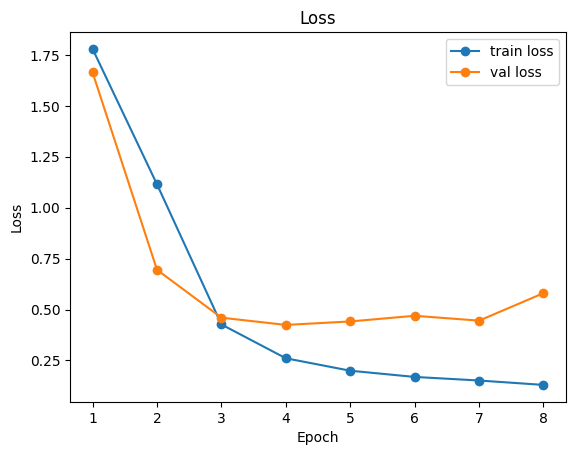

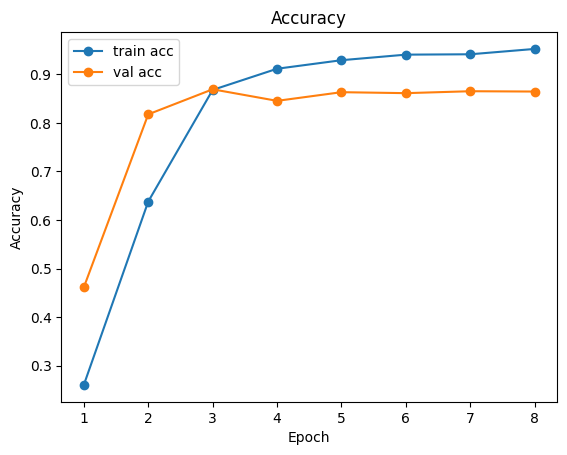

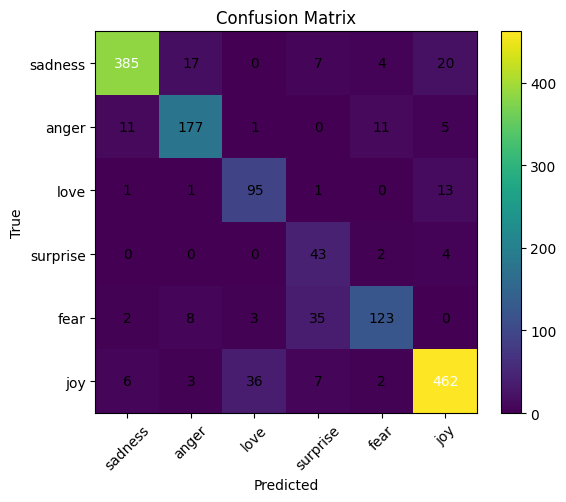

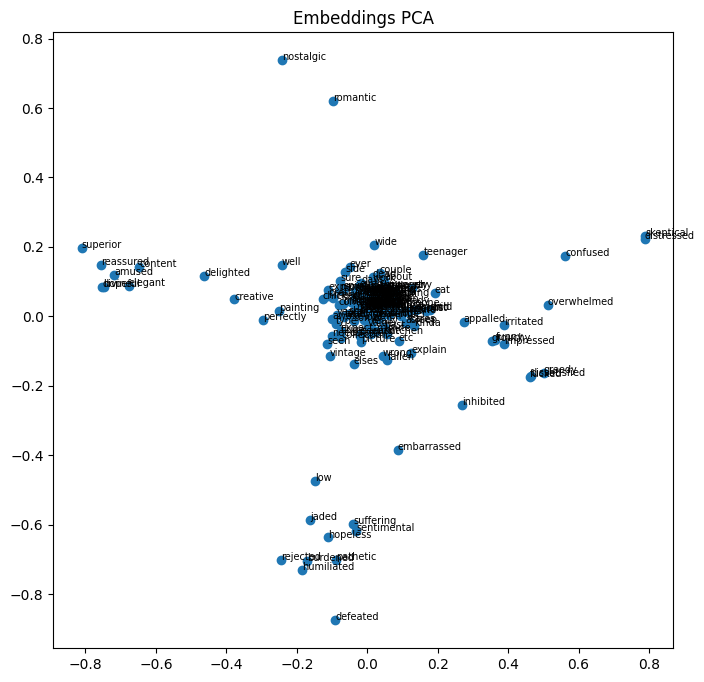

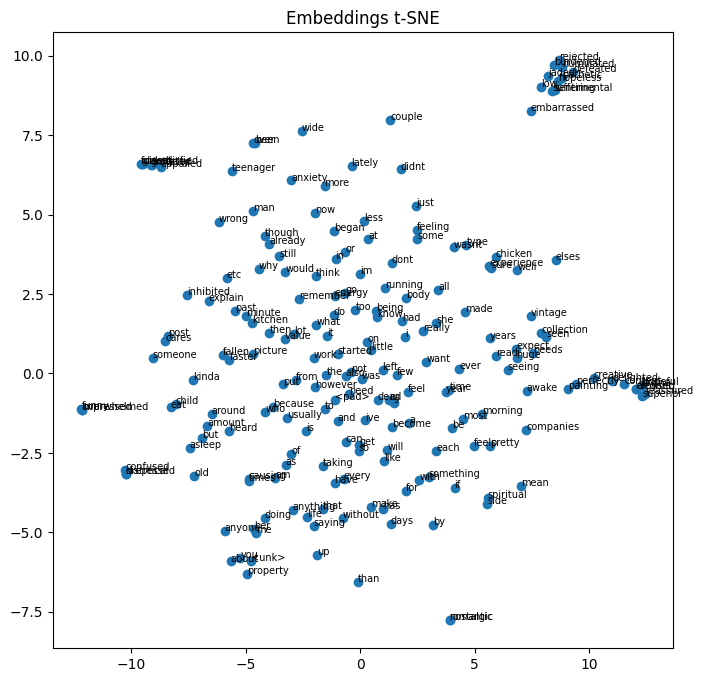

In [47]:
best_row = df.iloc[0]  # Getting best configuration
best_model_path = best_row["best_path"]

# Fix: Ensure batch_size is positive and all parameters are valid
cfg = {
    "batch_size": max(1, int(best_row["batch_size"])),  # Ensure positive integer
    "hidden_size": int(best_row["hidden_size"]),
    "emb_size": int(best_row["emb_size"]),
    "lr": float(best_row["lr"]),
    "size_threshold": int(best_row["size_threshold"]),
    "appearance_threshold": int(best_row["appearance_threshold"]),
    "rnn_layers": int(best_row["rnn_layers"])
}

print("Using configuration:", cfg)  # Debug print

# Re-run with fixed parameters
model, voc, itos, label2idx, history, saved_path = run_pipeline(
    train_path=train_path, 
    val_path=val_path, 
    test_path=test_path,
    batch_size=cfg["batch_size"],
    hidden_size=cfg["hidden_size"],
    emb_size=cfg["emb_size"],
    lr=cfg["lr"],
    size_threshold=cfg["size_threshold"],
    appearance_threshold=cfg["appearance_threshold"],
    rnn_layers=cfg["rnn_layers"],
    visualize=True,
    verbose=True,
    best_path=best_model_path
)

#### Approfondissement : Self-Supervised Learning

PIPELINE CBOW AUTO-SUPERVISÉ OPTIMISÉ
Device: cpu

 Construction du vocabulaire...
Taille du vocabulaire: 5,260 (min_freq=3, max=10000)
  - Mots spéciaux: ['<pad>', '<unk>']
  - Mots filtrés: 9,954

 Création des datasets...
  - Entraînement: 211,936 exemples
  - Validation: 25,891 exemples
  - Test: 26,438 exemples

 Exemples de paires (contexte -> mot cible):
  [i, can, go, feeling, so, hopeless] -> 'from'
  [can, go, from, so, hopeless, to] -> 'feeling'
  [go, from, feeling, hopeless, to, so] -> 'so'

 Initialisation du modèle...
Architecture:
    - Vocab size: 5,260
    - Embedding dim: 100
    - Context size: 3 (fenêtre de 6 mots)
    - Dropout: 0.3
    - Nombre total de paramètres: 1,057,260

 Début de l'entraînement (patience=7)...
Epoch 01/30 | Train: loss=7.4234 acc=0.048 | Val: loss=6.0243 acc=0.050 | LR=8.41e-04
Meilleur modèle sauvegardé
Epoch 02/30 | Train: loss=6.0618 acc=0.056 | Val: loss=5.8692 acc=0.077 | LR=2.28e-03
Meilleur modèle sauvegardé
Epoch 03/30 | Train: loss

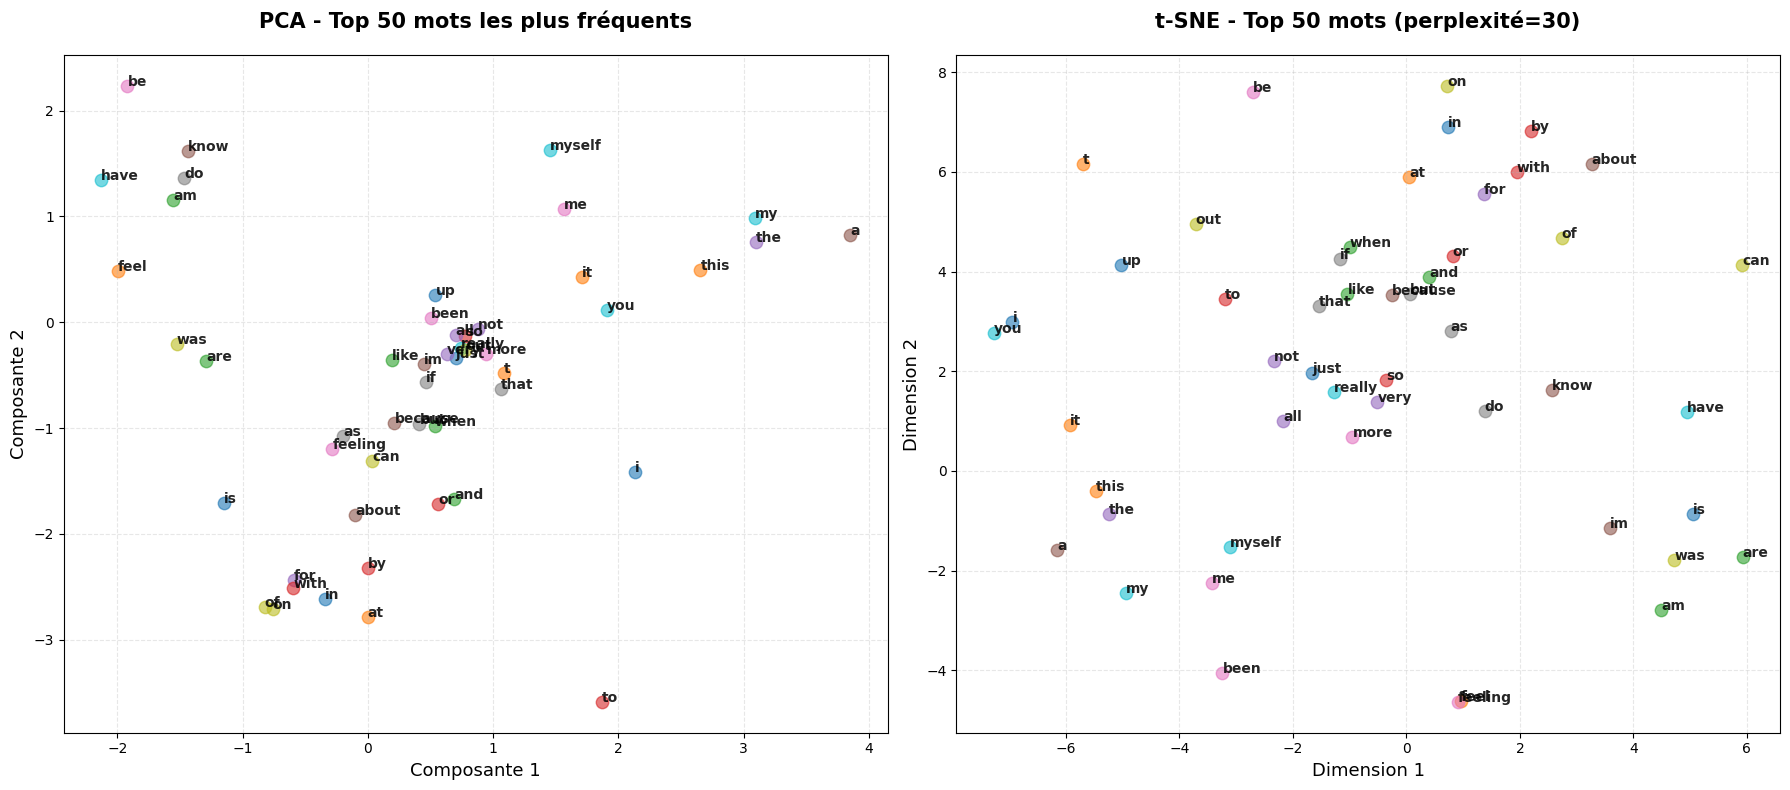


ANALYSE DES SIMILARITÉS SÉMANTIQUES

 Émotions positives:

  'happy':
    - thrilled        (similarité: 0.733)
    - charlie         (similarité: 0.721)
    - careful         (similarité: 0.688)
    - excited         (similarité: 0.662)
    - truthful        (similarité: 0.656)

  'love':
    - despised        (similarité: 0.614)
    - trust           (similarité: 0.609)
    - marvel          (similarité: 0.607)
    - overcome        (similarité: 0.595)
    - contact         (similarité: 0.593)

  'joy':
    - hotel           (similarité: 0.661)
    - depths          (similarité: 0.660)
    - chaos           (similarité: 0.642)
    - pain            (similarité: 0.635)
    - pocket          (similarité: 0.626)

 Émotions négatives:

  'sad':
    - angry           (similarité: 0.626)
    - paranoid        (similarité: 0.611)
    - confused        (similarité: 0.578)
    - dizzy           (similarité: 0.563)
    - surroundings    (similarité: 0.562)

  'hate':
    - remember        (si

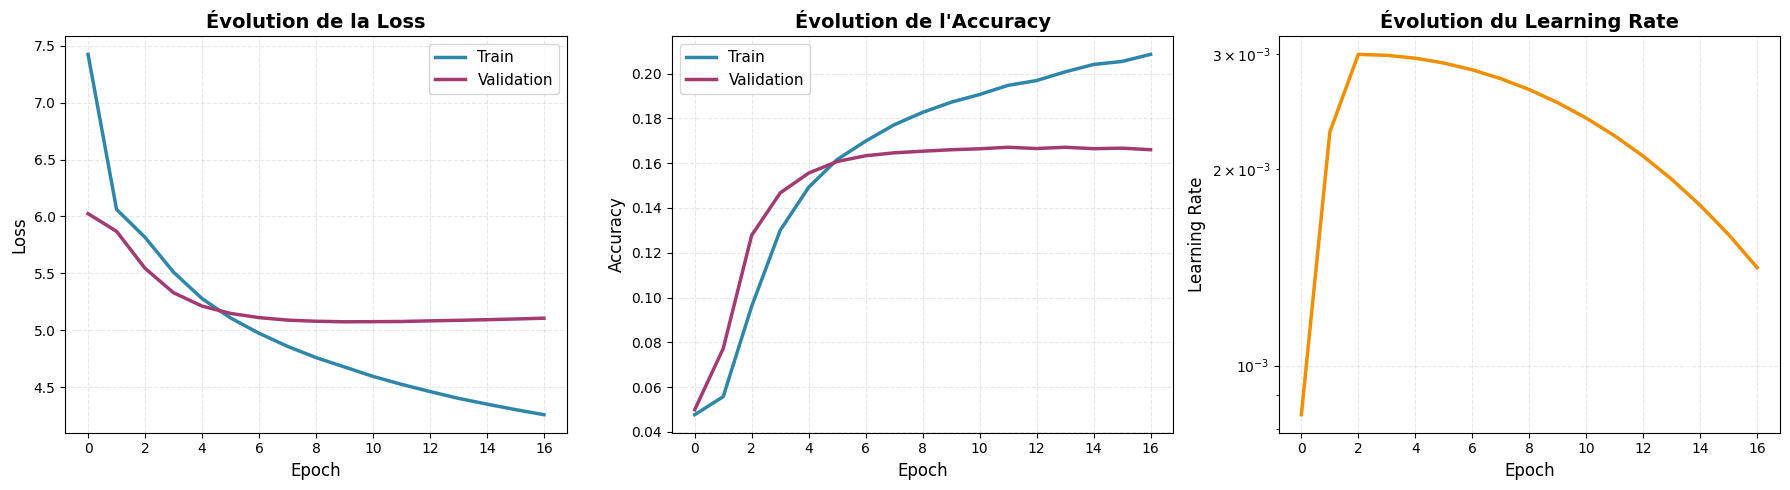


PIPELINE TERMINÉ


In [5]:
# -------------------------
# 8) Optional: auto-supervised training (next-word prediction)
# -------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import random

# -------------------------
# Dataset pour l'apprentissage auto-supervisé
# -------------------------
class SelfSupervisedDataset(Dataset):
    """
    Dataset pour l'apprentissage auto-supervisé de type CBOW.
    Chaque exemple est une paire (contexte, mot_cible) où le contexte est constitué de mots voisins.
    ------
    Paramètres:
        texts: Liste de textes à utiliser pour l'apprentissage.
        vocab: Dictionnaire mapping mots -> indices.
        context_size: Taille du contexte (nombre de mots voisins à considérer).
    """
    def __init__(self, texts: List[str], vocab, context_size: int = 2):
        """Initialisation du dataset."""
        self.texts = texts
        self.vocab = vocab
        self.context_size = context_size
        self.data = []

        # Préparer les paires (contexte, mot_cible)
        for text in texts:
            tokens = text.lower().split()
            indices = [self.vocab[token] if token in self.vocab else self.vocab["<unk>"] for token in tokens]

            for i in range(context_size, len(indices) - context_size):
                context = indices[i-context_size:i] + indices[i+1:i+context_size+1] # le contexte est la concaténation des indices des mots avant et après le mot cible
                target = indices[i]
                self.data.append((context, target))

    def __len__(self):
        """Longueur du dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """Récupérer un exemple du dataset."""
        context, target = self.data[idx]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

# -------------------------
# Modèle CBOW 
# -------------------------
class CBOWModel(nn.Module):
    """
    Modèle CBOW (Continuous Bag of Words) pour la prédiction de mots.
    ------
    Paramètres:
        vocab_size: Taille du vocabulaire.
        embedding_dim: Dimension des embeddings.
        context_size: Taille du contexte (nombre de mots voisins).
        dropout: Taux de dropout pour régularisation.
    """
    def __init__(self, vocab_size: int, embedding_dim: int, context_size: int, dropout: float = 0.3):
        """Initialisation du modèle CBOW."""
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # Architecture simplifiée : moyenne des embeddings -> projection directe
        self.projection = nn.Linear(embedding_dim, vocab_size) # projection des embeddings vers le vocabulaire
        self.dropout = nn.Dropout(dropout) # Dropout pour régularisation
        
        # Initialisation appropriée
        nn.init.xavier_uniform_(self.embeddings.weight)
        nn.init.xavier_uniform_(self.projection.weight)
        nn.init.zeros_(self.projection.bias)

    def forward(self, inputs):
        """Forward pass du modèle CBOW."""
        # inputs shape: (batch_size, 2*context_size)
        embeds = self.embeddings(inputs)  # (batch_size, 2*context_size, embedding_dim)
        
        # MOYENNE des embeddings du contexte (plus efficace que concaténation)
        context_embedding = embeds.mean(dim=1)  # (batch_size, embedding_dim)
        context_embedding = self.dropout(context_embedding)
        
        # Projection vers le vocabulaire
        out = self.projection(context_embedding)  # (batch_size, vocab_size)
        return out

# -------------------------
# Fonction de collate pour le dataset auto-supervisé
# -------------------------
def collate_self_supervised(batch):
    """
    Fonction de collate pour le dataset auto-supervisé.
    ------
    Paramètres:
        batch: Liste de tuples (contexte, mot_cible).
    ------
    Retour:
        contexts: Tensor des contextes.
        targets: Tensor des mots cibles."""
    contexts, targets = zip(*batch)
    return torch.stack(contexts), torch.stack(targets)

# -------------------------
# Pipeline d'apprentissage auto-supervisé OPTIMISÉ
# -------------------------
def run_self_supervised_pipeline(train_path: str, val_path: str, test_path: str,
                                sep: str = ";",
                                specials: List[str] = ["<pad>", "<unk>"],
                                min_freq: int = 3,  # Réduit le vocabulaire
                                max_vocab_size: int = 10000,  # Limite le vocabulaire
                                batch_size: int = 256,  # Augmenté pour plus de stabilité
                                embedding_dim: int = 100,  # Réduit pour commencer
                                context_size: int = 3,  # Augmenté pour plus de contexte
                                dropout: float = 0.3,  # Réduit
                                n_epochs: int = 30,
                                lr: float = 0.003,  # Augmenté
                                weight_decay: float = 1e-6,  # Réduit
                                patience: int = 7,  # Augmenté
                                device = None):
    """
    Pipeline d'apprentissage auto-supervisé de type CBOW optimisé.
    ------
    Paramètres:
        train_path: Chemin vers le fichier d'entraînement.
        val_path: Chemin vers le fichier de validation.
        test_path: Chemin vers le fichier de test.
        sep: Séparateur de champs dans les fichiers.
        specials: Liste des tokens spéciaux.
        min_freq: Fréquence minimale pour inclure un mot dans le vocabulaire.
        max_vocab_size: Taille maximale du vocabulaire.
        batch_size: Taille des batches.
        embedding_dim: Dimension des embeddings.
        context_size: Taille du contexte (nombre de mots voisins).
        dropout: Taux de dropout pour régularisation.
        n_epochs: Nombre d'époques d'entraînement.
        lr: Taux d'apprentissage.
        weight_decay: Poids de la régularisation L2.
        patience: Nombre d'époques sans amélioration avant arrêt précoce.
        device: Dispositif d'entraînement (CPU ou GPU).
    ------
    Retour:
        model : Modèle CBOW entraîné.
        voc : Vocabulaire (mot -> index).
        itos : Vocabulaire inversé (index -> mot).
        embeddings : Matrice des embeddings (vocab_size, embedding_dim).
        history : Historique des pertes d'entraînement.
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("=" * 70)
    print("PIPELINE CBOW AUTO-SUPERVISÉ OPTIMISÉ")
    print("=" * 70)
    print(f"Device: {device}")

    # 1) Chargement des données
    train_texts, train_labels = load_file(train_path, sep=sep)
    val_texts, val_labels = load_file(val_path, sep=sep)
    test_texts, test_labels = load_file(test_path, sep=sep)

    if not train_texts:
        print(f"Erreur: Données d'entraînement vides depuis {train_path}")
        return None, None, None, None

    # 2) Construction du vocabulaire OPTIMISÉ
    print("\n Construction du vocabulaire...")
    word_freq = {}
    for text in train_texts:
        for word in text.lower().split():
            word_freq[word] = word_freq.get(word, 0) + 1
    
    # Filtrer par min_freq et limiter la taille
    filtered_words = {word: freq for word, freq in word_freq.items() if freq >= min_freq}
    sorted_words = sorted(filtered_words.items(), key=lambda x: x[1], reverse=True)
    
    if max_vocab_size:
        sorted_words = sorted_words[:max_vocab_size - len(specials)]
    
    voc = {token: idx for idx, token in enumerate(specials)}
    for word, _ in sorted_words:
        if word not in voc:
            voc[word] = len(voc)
    
    print(f"Taille du vocabulaire: {len(voc):,} (min_freq={min_freq}, max={max_vocab_size})")
    print(f"  - Mots spéciaux: {specials}")
    print(f"  - Mots filtrés: {len(word_freq) - len(voc) + len(specials):,}")
    
    itos = {idx: token for token, idx in voc.items()}

    # 3) Datasets et DataLoaders
    print("\n Création des datasets...")
    train_ss_ds = SelfSupervisedDataset(train_texts, voc, context_size=context_size)
    val_ss_ds = SelfSupervisedDataset(val_texts, voc, context_size=context_size)
    test_ss_ds = SelfSupervisedDataset(test_texts, voc, context_size=context_size)

    print(f"  - Entraînement: {len(train_ss_ds):,} exemples")
    print(f"  - Validation: {len(val_ss_ds):,} exemples")
    print(f"  - Test: {len(test_ss_ds):,} exemples")

    # Afficher quelques exemples
    print("\n Exemples de paires (contexte -> mot cible):")
    for i in range(min(3, len(train_ss_ds))):
        context, target = train_ss_ds[i]
        context_words = [itos[idx.item()] for idx in context]
        target_word = itos[target.item()]
        print(f"  [{', '.join(context_words)}] -> '{target_word}'")

    train_ss_loader = DataLoader(train_ss_ds, batch_size=batch_size, shuffle=True,
                                 collate_fn=collate_self_supervised, num_workers=0)
    val_ss_loader = DataLoader(val_ss_ds, batch_size=batch_size, shuffle=False,
                               collate_fn=collate_self_supervised, num_workers=0)
    test_ss_loader = DataLoader(test_ss_ds, batch_size=batch_size, shuffle=False,
                                collate_fn=collate_self_supervised, num_workers=0)

    # 4) Modèle CBOW simplifié
    print("\n Initialisation du modèle...")
    vocab_size = len(voc)
    model = CBOWModel(vocab_size, embedding_dim, context_size, dropout=dropout).to(device)
    
    print(f"Architecture:")
    print(f"    - Vocab size: {vocab_size:,}")
    print(f"    - Embedding dim: {embedding_dim}")
    print(f"    - Context size: {context_size} (fenêtre de {2*context_size} mots)")
    print(f"    - Dropout: {dropout}")
    
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"    - Nombre total de paramètres: {total_params:,}")

    # 5) Loss et optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Scheduler avec warmup
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr,
        epochs=n_epochs,
        steps_per_epoch=len(train_ss_loader),
        pct_start=0.1  # 10% de warmup
    )

    # 6) Boucle d'entraînement
    print(f"\n Début de l'entraînement (patience={patience})...")
    print("=" * 70)
    
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}
    best_val_loss = float('inf')
    patience_counter = 0
    best_path = "best_cbow_model.pt"

    def compute_accuracy(outputs, targets):
        """
        Calcul de l'accuracy.
        ------
        Paramètres:
            outputs: Sorties du modèle (logits).
            targets: Cibles réelles.
        ------
        Retour:
            accuracy: Précision (accuracy) calculée.
        """
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == targets).sum().item()
        return correct / targets.size(0)

    for epoch in range(1, n_epochs + 1):
        # === ENTRAÎNEMENT ===
        model.train()
        total_loss = 0
        total_acc = 0
        for contexts, targets in train_ss_loader:
            contexts, targets = contexts.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(contexts)
            loss = criterion(outputs, targets)
            loss.backward()

            # Gradient clipping léger pour stabilité
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            optimizer.step()
            scheduler.step()  # Update LR après chaque batch

            total_loss += loss.item()
            total_acc += compute_accuracy(outputs, targets)

        train_loss = total_loss / len(train_ss_loader)
        train_acc = total_acc / len(train_ss_loader)

        # === VALIDATION ===
        model.eval()
        total_val_loss = 0
        total_val_acc = 0
        with torch.no_grad():
            for contexts, targets in val_ss_loader:
                contexts, targets = contexts.to(device), targets.to(device)
                outputs = model(contexts)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item()
                total_val_acc += compute_accuracy(outputs, targets)

        val_loss = total_val_loss / len(val_ss_loader)
        val_acc = total_val_acc / len(val_ss_loader)
        current_lr = scheduler.get_last_lr()[0]

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["lr"].append(current_lr)

        # Affichage
        print(f"Epoch {epoch:02d}/{n_epochs} | "
              f"Train: loss={train_loss:.4f} acc={train_acc:.3f} | "
              f"Val: loss={val_loss:.4f} acc={val_acc:.3f} | "
              f"LR={current_lr:.2e}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
            }, best_path)
            print("Meilleur modèle sauvegardé")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping à l'epoch {epoch}")
                break

    # 7) Évaluation finale
    print("\n" + "=" * 70)
    print("ÉVALUATION FINALE")
    print("=" * 70)
    
    checkpoint = torch.load(best_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    total_test_loss = 0
    total_test_acc = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for contexts, targets in test_ss_loader:
            contexts, targets = contexts.to(device), targets.to(device)
            outputs = model(contexts)
            loss = criterion(outputs, targets)
            total_test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            total_test_acc += compute_accuracy(outputs, targets)

    test_loss = total_test_loss / len(test_ss_loader)
    test_acc = total_test_acc / len(test_ss_loader)

    print(f"\nRésultats sur le test:")
    print(f"  - Loss: {test_loss:.4f}")
    print(f"  - Accuracy: {test_acc:.3f} ({test_acc*100:.1f}%)")
    print(f"  - Meilleure val loss (epoch {checkpoint['epoch']}): {checkpoint['val_loss']:.4f}")

    # 8) Visualisation des embeddings
    print("\n" + "=" * 70)
    print("VISUALISATION DES EMBEDDINGS")
    print("=" * 70)
    
    embeddings = model.embeddings.weight.data.cpu().numpy()

    # Sélection des mots les plus fréquents
    top_n = 100
    word_freq_sorted = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    top_words = [(w, f) for w, f in word_freq_sorted if w in voc][:top_n]
    top_indices = [voc[word] for word, _ in top_words]

    # PCA
    pca = PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings)
    print(f"PCA: variance expliquée = {pca.explained_variance_ratio_.sum():.2%}")

    # t-SNE
    perplexity = min(30, len(top_indices) // 3)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    embeddings_tsne = tsne.fit_transform(embeddings[top_indices])

    # Plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # PCA plot (top 50)
    display_n = 50
    for i, idx in enumerate(top_indices[:display_n]):
        word = itos[idx]
        ax1.scatter(embeddings_pca[idx, 0], embeddings_pca[idx, 1], 
                   alpha=0.6, s=80, c=f'C{i % 10}')
        ax1.annotate(word, (embeddings_pca[idx, 0], embeddings_pca[idx, 1]),
                    fontsize=10, alpha=0.85, weight='bold')
    ax1.set_title(f'PCA - Top {display_n} mots les plus fréquents', 
                 fontsize=15, fontweight='bold', pad=20)
    ax1.set_xlabel('Composante 1', fontsize=13)
    ax1.set_ylabel('Composante 2', fontsize=13)
    ax1.grid(True, alpha=0.3, linestyle='--')

    # t-SNE plot (top 50)
    for i, idx in enumerate(top_indices[:display_n]):
        word = itos[idx]
        ax2.scatter(embeddings_tsne[i, 0], embeddings_tsne[i, 1], 
                   alpha=0.6, s=80, c=f'C{i % 10}')
        ax2.annotate(word, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]),
                    fontsize=10, alpha=0.85, weight='bold')
    ax2.set_title(f't-SNE - Top {display_n} mots (perplexité={perplexity})', 
                 fontsize=15, fontweight='bold', pad=20)
    ax2.set_xlabel('Dimension 1', fontsize=13)
    ax2.set_ylabel('Dimension 2', fontsize=13)
    ax2.grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()

    # 9) Analyse sémantique
    print("\n" + "=" * 70)
    print("ANALYSE DES SIMILARITÉS SÉMANTIQUES")
    print("=" * 70)

    def find_similar_words(word, embeddings, vocab, itos, top_k=5):
        """
        Trouver les mots les plus similaires à un mot donné.
        ------
        Paramètres:
            word: Mot de référence.
            embeddings: Matrice des embeddings.
            vocab: Vocabulaire (mot -> index).
            itos: Vocabulaire inversé (index -> mot).
            top_k: Nombre de mots similaires à retourner.
        ------
        Retour:
            Liste de tuples (mot, similarité)."""
        if word not in vocab:
            return None

        word_idx = vocab[word]
        word_embedding = embeddings[word_idx]

        # Cosine similarity (vectorisé)
        word_norm = word_embedding / (np.linalg.norm(word_embedding) + 1e-10)
        embeddings_norm = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-10)
        similarities = embeddings_norm @ word_norm

        # Top-k (sans le mot lui-même)
        top_indices = np.argsort(similarities)[::-1][1:top_k+1]
        return [(itos[idx], float(similarities[idx])) for idx in top_indices]

    # Test sur plusieurs catégories
    test_categories = {
        "Émotions positives": ["happy", "love", "joy", "good", "beautiful", "wonderful"],
        "Émotions négatives": ["sad", "hate", "angry", "bad", "terrible", "awful"],
        "Sentiments": ["feel", "like", "want", "need", "think", "know"]
    }

    for category, words in test_categories.items():
        available = [w for w in words if w in voc]
        if available:
            print(f"\n {category}:")
            for word in available[:3]:
                similar = find_similar_words(word, embeddings, voc, itos, top_k=5)
                if similar:
                    print(f"\n  '{word}':")
                    for sim_word, score in similar:
                        print(f"    - {sim_word:<15} (similarité: {score:.3f})")

    # 10) Courbes d'apprentissage
    print("\n Génération des courbes d'apprentissage...")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Loss
    axes[0].plot(history["train_loss"], label="Train", linewidth=2.5, color='#2E86AB')
    axes[0].plot(history["val_loss"], label="Validation", linewidth=2.5, color='#A23B72')
    axes[0].set_title("Évolution de la Loss", fontsize=14, fontweight='bold')
    axes[0].set_xlabel("Epoch", fontsize=12)
    axes[0].set_ylabel("Loss", fontsize=12)
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3, linestyle='--')

    # Accuracy
    axes[1].plot(history["train_acc"], label="Train", linewidth=2.5, color='#2E86AB')
    axes[1].plot(history["val_acc"], label="Validation", linewidth=2.5, color='#A23B72')
    axes[1].set_title("Évolution de l'Accuracy", fontsize=14, fontweight='bold')
    axes[1].set_xlabel("Epoch", fontsize=12)
    axes[1].set_ylabel("Accuracy", fontsize=12)
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3, linestyle='--')

    # Learning rate
    axes[2].plot(history["lr"], linewidth=2.5, color='#F18F01')
    axes[2].set_title("Évolution du Learning Rate", fontsize=14, fontweight='bold')
    axes[2].set_xlabel("Epoch", fontsize=12)
    axes[2].set_ylabel("Learning Rate", fontsize=12)
    axes[2].set_yscale('log')
    axes[2].grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 70)
    print("PIPELINE TERMINÉ")
    print("=" * 70)

    return model, voc, itos, embeddings, history

# -------------------------
# Utilisation du pipeline
# -------------------------
train_path = "./dataset/train.txt"
val_path = "./dataset/val.txt"
test_path = "./dataset/test.txt"

model, voc, itos, embeddings, history = run_self_supervised_pipeline(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    min_freq=3,           # Filtrage des mots rares
    max_vocab_size=10000, # Limite à 10k mots
    embedding_dim=100,    # Commence plus petit
    context_size=3,       # Plus de contexte
    dropout=0.3,          # Moins agressif
    n_epochs=30,
    batch_size=256,       # Plus grand
    lr=0.003,             # Plus élevé
    weight_decay=1e-6,
    patience=7
)